## Part 1: 
Load data, clean, and save aggregate data

In [80]:
import pandas as pd 
import os
import numpy as np
from data_cleaning import change_columns_types
from data_loading import aggregate_data
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#immport necessary libraries and filter warnings
import warnings
 
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import nfl_data_py as nfl
from sklearn.impute import SimpleImputer
from utility_db_25 import mark_columns, TrainML, build_catboost, optuna_call, test_ML, build_transformer, get_momentum_cols, create_momentum_index, get_final_features, get_motion_cols, motion_complexity_score
from team_logos import graph_run_pass, get_logo_df, load_previous_year_passruns
warnings.filterwarnings("ignore")

In [81]:
#graph_run_pass()

In [82]:
root_dir = os.getcwd()

load_saved_data = True # if you change this to true you can load presaved data
games_fname= os.path.join(root_dir, "data/games.csv")
plays_fname = os.path.join(root_dir,  "data/plays.csv")

if not load_saved_data: 
    players_fname = os.path.join(root_dir,  "data/players.csv")
    player_plays_fname = os.path.join(root_dir,  "data/player_play.csv")
    c21_fname = os.path.join(root_dir, 'data_21/cov_21.csv')
    pr21_fname = os.path.join(root_dir, 'data_21/team_pr_21.csv')
    xp_fname = os.path.join(root_dir, "data/team_xpass_ratios.csv")
    pr_fname = os.path.join(root_dir, "data/team_pass_rates.csv")
    cf_fname = os.path.join(root_dir, "data/coverages_faced.csv")
    cu_fname = os.path.join(root_dir, 'data/coverages_used.csv')
    inj_fname = os.path.join(root_dir, 'data/snaps_lost_injury.csv')
    qbr_fname = os.path.join(root_dir, 'data/qbr_data.csv')
    def_fname_train = os.path.join(root_dir, 'data/def_train.csv')
    def_fname_test = os.path.join(root_dir, 'data/def_test.csv')
    tracking_fname_list_train = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,9)] #weeks 1-8 are training data
    tracking_fname_list_test = [os.path.join(root_dir,  "data/tracking_week_9.csv")] #week 9 is test data
    train_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_train, games_fname, xp_fname, pr_fname, cu_fname,inj_fname, c21_fname, pr21_fname, qbr_fname, def_fname_train, 'train')
    train_data.to_csv(os.path.join(root_dir, "data/train_data.csv"), index=False)
    test_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_test, games_fname, xp_fname, pr_fname, cu_fname,inj_fname, c21_fname, pr21_fname, qbr_fname, def_fname_test, 'test')
    test_data.to_csv(os.path.join(root_dir, "data/test_data.csv"), index=False)
else:
    train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
    test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
print('train colums: ', len(train_data.columns))
print('test colums: ', len(test_data.columns))

train colums:  457
test colums:  361


In [83]:
include_columns=[x for x in test_data.columns if '_def' not in x]+['pass_rate_def']
train_data=train_data[include_columns]
test_data = test_data[include_columns]

In [84]:
motion_cols=get_motion_cols(train_data.columns)
momentum_cols=get_momentum_cols(train_data.columns)

In [85]:
train_data=create_momentum_index(train_data, momentum_cols)
test_data=create_momentum_index(test_data, momentum_cols)

train_data=motion_complexity_score(train_data, motion_cols)
test_data=motion_complexity_score(test_data, motion_cols)

## Goal: 
To predict pass attempts for each play with greater accuracy and precision than the baseline dummy classifier. The base rate is about 60%. We will look at the offensive players' tracking data, along with characteristics of the play including the offensive formation and receiver alignment.

## General Strategy:
1. Read all data
2. Merge data
3. Filter data for offensive players, plays not nullified by a penalty, and data before the snap
4. Create a target variable 'pass' to indicate if a pass was attempted
5. Feature engineering and feature selection
6. Test baseline models
7. Tune models

In [86]:

for col in train_data.columns: 
    if col != 'pass':
        if round((train_data[col].isna().sum() /len(train_data)*100), 2)>75:
            train_data.drop(columns=col, inplace=True)
        elif round((train_data[col].isna().sum() /len(train_data)*100), 2)>0:
            print(col,round((train_data[col].isna().sum() /len(train_data)*100), 2), '% missing')
        else: 
            continue

time_remaining 0.81 % missing
pass_rush_ratio 2.84 % missing
temp 9.67 % missing
humidity 5.64 % missing
wind 8.97 % missing


In [87]:
train_data=change_columns_types(train_data)
test_data=change_columns_types(test_data)

In [88]:
final_features=get_final_features(train_data,threshold=.5,trim_rows=0)

In [89]:
#final_features.remove('xpass_situational')

In [90]:
#final_features.remove('down')
#final_features.remove('yardsToGo')

In [91]:
len(final_features)

22

In [92]:
final_features

['a|max|FB_1',
 'is_motion',
 'a|max|TE_2',
 's|max|RB_1',
 'QBdff_T',
 'pass',
 'down',
 'a|max|TE_3',
 'x_standard|mean|T_1_QBdiff',
 'x_standard|mean|RB_1_QBdiff',
 'off_xpass',
 'QBdff_WR',
 'a|max|WR_3',
 'mean_pairwise_dist',
 'neg_alignment',
 'neg_Formations',
 'motion-momentum',
 's|max|QB_1',
 'QBdffy_RB',
 'xpass_situational',
 'yardsToGo',
 'receiverAlignment_3x2']

In [93]:
final_features=['pass','xpass_situational',  'QB_RB1_offset', 'db_ct', 'QBdffy_RB',#'presnap_momentum', #'QBdff_T',
        'motion-momentum',
        'n_offense_backfield',  'neg_Formations','mean_pairwise_dist']
numeric_columns, cat_columns = mark_columns(df=train_data,features=final_features, nc=None,cc = None)

<Axes: title={'center': 'Correlation Heatmap of Features'}>

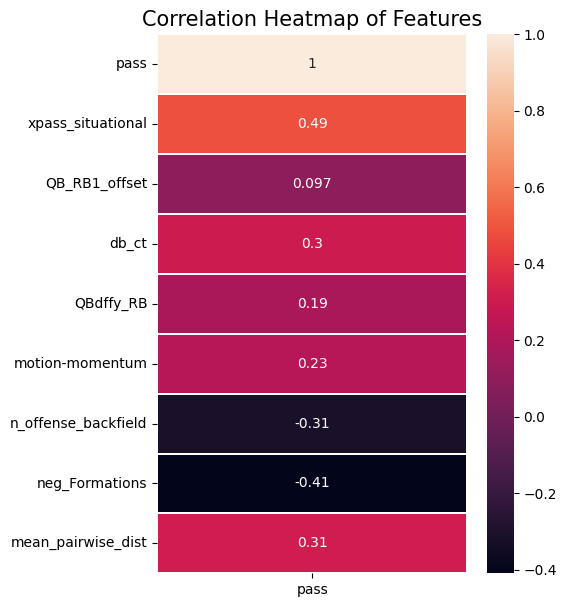

In [94]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,7))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(train_data[final_features].corr()[['pass']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

In [95]:
# Create an imputer object with mean strategy
#imputer = SimpleImputer(strategy='mean')
from sklearn.compose import ColumnTransformer


# Fit and transform the data
#merged_pivot[numeric_columns] = imputer.fit_transform(merged_pivot[numeric_columns])
imputer = SimpleImputer(missing_values = np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns),('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [96]:
#create a function to train ML models and return ROC_AUC and accuracy scores
SEED=42
n_splits=5
#X=merged_pivot[selected_features]
X=train_data[final_features].drop(columns='pass')

y=train_data['pass']

Training Folds: 100%|██████████| 5/5 [00:00<00:00, 40.83it/s]

Mean Train AUC --> 0.5000
Mean Validation AUC ---> 0.5000
Mean Train Accuracy --> 0.6046
Mean Validation Accuracy ---> 0.6046


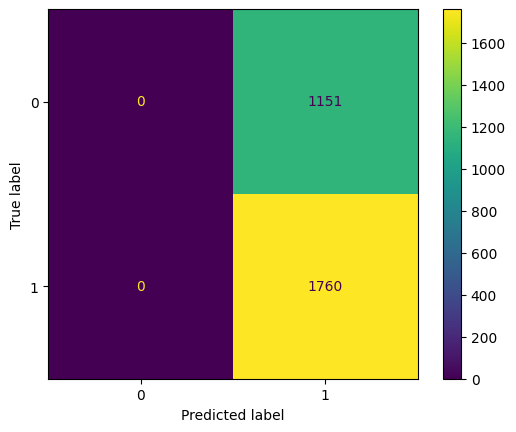

In [97]:
#get baseline value from dummy classifier
dummypipeline=Pipeline([('tr', transformer), ('dummy', DummyClassifier(strategy="most_frequent"))], verbose = True)
TrainML(dummypipeline,X, y, n_splits,SEED)

Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

Mean Train AUC --> 0.8210
Mean Validation AUC ---> 0.7675
Mean Train Accuracy --> 0.8321
Mean Validation Accuracy ---> 0.7811


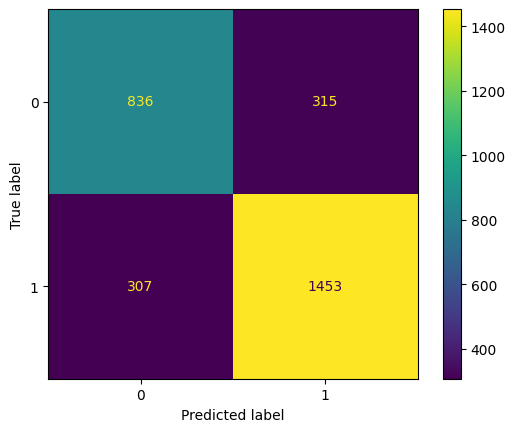

In [98]:
#lgbm classifier
pipeline=Pipeline([('tr', transformer), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
lgb = LGBMClassifier(verbosity=-1,seed=42).fit(X,y)
TrainML(pipeline,X, y,n_splits,SEED)

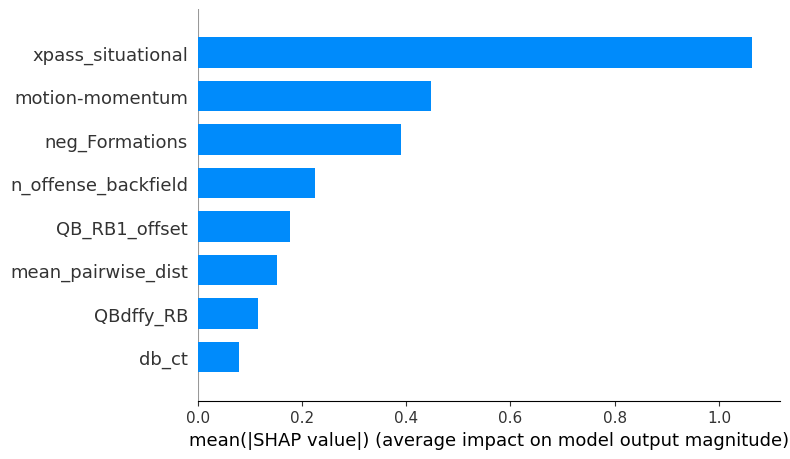

In [99]:
import shap 

shap_values = shap.TreeExplainer(lgb).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

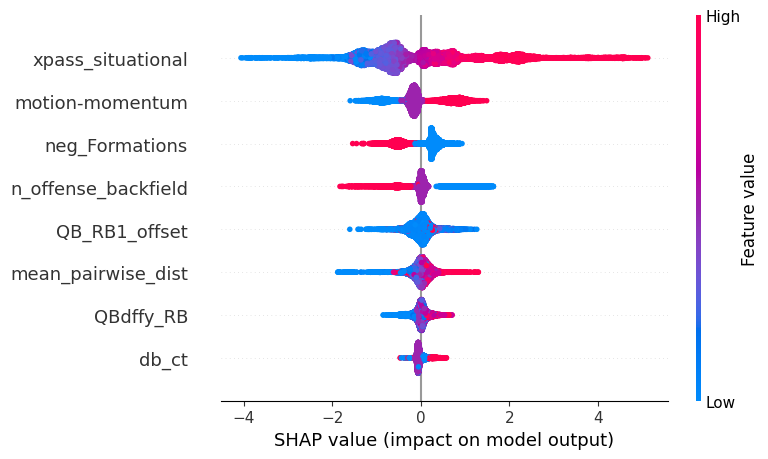

In [100]:
shap.summary_plot(shap_values, X)

In [101]:
final_features.remove('pass')

<Axes: >

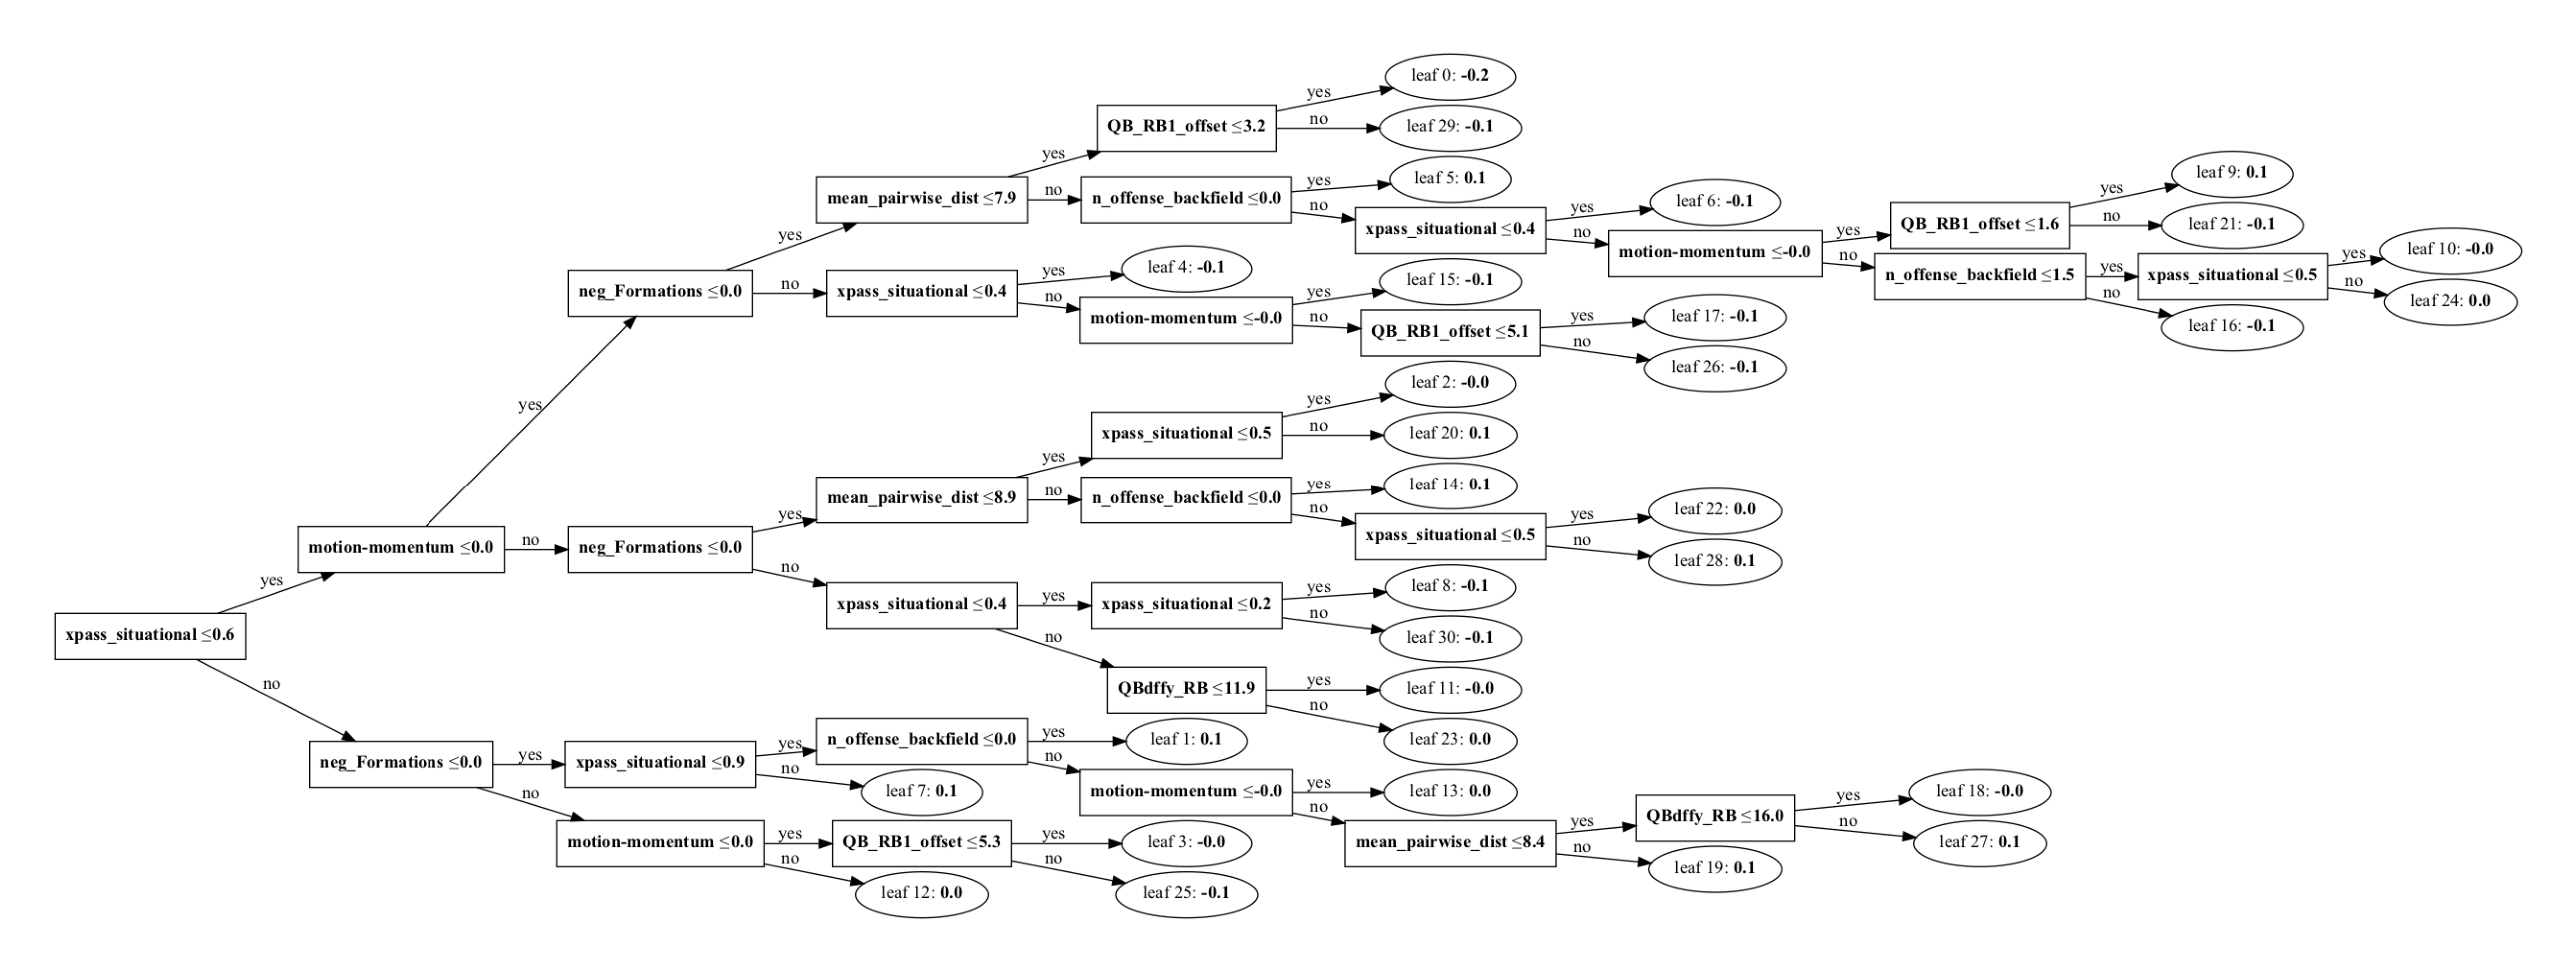

In [102]:
from catboost import  Pool, MetricVisualizer
import ipywidgets as widgets
%matplotlib inline
#need graphviz for this part and to add to path https://graphviz.org/download/

# For explicitly displaying widgets
from IPython.display import display
import lightgbm


lightgbm.plot_tree(lgb, tree_index=3,dpi=500,precision=1)
#lightgbm.plot_tree(lgb, tree_index=1,dpi=300, ax=ax[1])

In [103]:
final_features=['xpass_situational',  'QB_RB1_offset','off_xpass','n_offense_backfield',#'receiverAlignment_3x2' #'QBdffy_RB', 'QBdff_T', 
        'motion-momentum',    
        'neg_Formations', 'mean_pairwise_dist']
final_numeric_columns, final_cat_columns = mark_columns(df=train_data,features=final_features, nc=numeric_columns,cc = cat_columns)

In [104]:
from sklearn.compose import ColumnTransformer
# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, final_numeric_columns),
        ('scaler', MinMaxScaler(), final_numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [105]:
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
#best_features=['xpass_situational', 'presnap_motion_complexity', 'presnap_momentum', 'receiverAlignment_3x2', 'offenseFormation_SINGLEBACK']

X=train_data[final_features]

y=train_data['pass']
# Define the helper function so that it can be reused

#cat_params = optuna_call(transformer,X,y,SKF,n_trials=20)

In [106]:
transformer_impute = build_transformer(imputer,numeric_columns,kind='imputer')
transformer_scale = build_transformer(imputer,numeric_columns,kind='scaler')

### Get proper validation indicies

Using week 8 holdout:

In [107]:
# import relevant play/week info
plays_df = pd.read_csv(plays_fname)[['gameId','playId']]
games_df = pd.read_csv(games_fname)[['gameId','week']]
id_week = plays_df.merge(games_df,how='left')

# mark train data with week info
train_marked = train_data.merge(id_week,how='left')

Use only week 2 onward:

In [108]:
# truncate to week 2 on, get length of week 8
train_trunc = train_marked.loc[train_marked[(train_marked['week'] >=2)].index]
w8_len = len(train_trunc[train_trunc['week'] == 8].index)

# -1 is train, 1 is holdout, per predefinedsplit parlance
ind_train = [-1]*(len(train_trunc)-w8_len)
ind_val = [1]*w8_len

# sanity check our split
len(ind_train) == len(train_trunc[train_trunc['week'] < 8])
len(ind_train+ind_val) == len(train_trunc)

True

Define our train/val split (by week 8 indices):

In [109]:
cv_ind = ind_train+ind_val
ps = PredefinedSplit(test_fold=cv_ind)

Redefine our X/y to exclude week 2:

In [110]:
X = train_trunc[final_features]
y = train_trunc['pass']

### Validation grid search:

In [111]:
from sklearn.model_selection import GridSearchCV

# Initialize an empty dictionary to store the best hyperparameters and their values
best_hyperparameters = {}
best_values = {}
 
# Initialize the LightGBM classifier
lgb_classifier = lightgbm.LGBMClassifier(force_col_wise=True, deterministic=True, random_state=42)

# Define a range of values for the hyperparameters to search through
param_grid = {
    'boosting_type' : ['gbdt', 'dart'],
    'num_leaves': [25, 30, 40, 50],
    'learning_rate': [ 0.1,.15],
    'depth': [4,5,6,7],
    'n_estimators': [75, 100],
    #'is_unbalance': [True],
    'random_state': [42],
    "deterministic": [True]
}


#Initialize GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid,
                           scoring='accuracy', cv=ps)
 

# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(X,y)
 
# Get the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())

'''
for i in range(5):
    key = 'split' + str(i) + '_test_score'
    print(np.mean(grid_search.cv_results_[key])
'''

best_params


{'boosting_type': 'dart',
 'depth': 4,
 'deterministic': True,
 'learning_rate': 0.15,
 'n_estimators': 100,
 'num_leaves': 30,
 'random_state': 42}

In [112]:
grid_search.best_score_

0.7875706214689265

In [113]:
best_params = {'boosting_type': 'dart',
 'depth': 4,
 'deterministic': True,
 'learning_rate': 0.1,
 'n_estimators': 75,
 'num_leaves': 50,
 'random_state': 42}

In [114]:
train_data['pass'].value_counts()

1    8801
0    5755
Name: pass, dtype: int64

In [115]:
# Train a LightGBM model with the best hyperparameters
best_model = lightgbm.LGBMClassifier(**best_params)
best_model.fit(X,y)

LGBMClassifier(boosting_type='dart', depth=4, deterministic=True,
               n_estimators=75, num_leaves=50, random_state=42)

In [116]:
y_pred = best_model.predict(test_data[final_features])
y_test = test_data['pass']

In [117]:
accuracy_score(y_test, y_pred)

0.8254901960784313

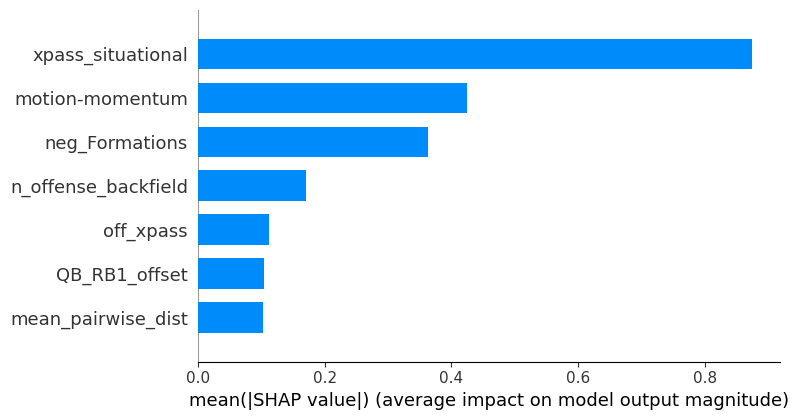

In [118]:
shap_values = shap.TreeExplainer(best_model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
feature_names = final_features


lgbm_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(lgbm_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)


In [119]:
shap_importance.head(8).set_index('col_name').T.columns

Index(['xpass_situational', 'motion-momentum', 'neg_Formations',
       'n_offense_backfield', 'off_xpass', 'QB_RB1_offset',
       'mean_pairwise_dist'],
      dtype='object', name='col_name')

AUC --> 0.8157745480326125
Accuracy --> 0.8254901960784313


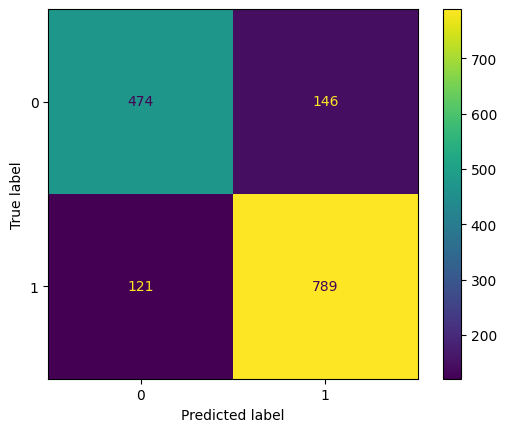

In [120]:
test_ML(test_data, best_model,final_features,transformer_impute,transformer_scale)

In [121]:
# Obtain gain feature importance
gain_importance = best_model.feature_importances_

# Display feature importance with feature names
feature_names = X[final_features]
gain_importance_df = pd.DataFrame({'Feature': final_features, 'Gain': gain_importance})
gain_importance_df.sort_values(by='Gain', ascending=False).head(25).set_index('Feature').T.columns

Index(['QB_RB1_offset', 'xpass_situational', 'off_xpass', 'mean_pairwise_dist',
       'motion-momentum', 'n_offense_backfield', 'neg_Formations'],
      dtype='object', name='Feature')

In [122]:
len(final_features)

7

In [123]:
X[final_features].corr()

,xpass_situational,QB_RB1_offset,off_xpass,n_offense_backfield,motion-momentum,neg_Formations,mean_pairwise_dist
xpass_situational,1.000000,0.082670,0.143791,-0.279206,0.081081,-0.459035,0.392132
QB_RB1_offset,0.082670,1.000000,-0.030410,-0.216569,0.024976,-0.132096,0.119167
off_xpass,0.143791,-0.030410,1.000000,-0.106761,0.080880,-0.172907,0.138470
n_offense_backfield,-0.279206,-0.216569,-0.106761,1.000000,-0.048166,0.336809,-0.330125
motion-momentum,0.081081,0.024976,0.080880,-0.048166,1.000000,-0.124009,0.023917
neg_Formations,-0.459035,-0.132096,-0.172907,0.336809,-0.124009,1.000000,-0.391906
mean_pairwise_dist,0.392132,0.119167,0.138470,-0.330125,0.023917,-0.391906,1.000000


In [124]:
final_features

['xpass_situational',
 'QB_RB1_offset',
 'off_xpass',
 'n_offense_backfield',
 'motion-momentum',
 'neg_Formations',
 'mean_pairwise_dist']

### Feature insights

The feature n_offense_backfield (assumedly # of rb's/players in the backfield?) seemingly has two problematic correlations of +/-.33 (with neg_Formations and mean_pairwise_dist), but receiver_alignment_3x2 has a more severe one (nearly .39) with QB_RB1_offset. 

The QB_RB1_offset correlation is likely a product of 3x2 formations either predicting a zero-RB set or an RB lined up as a receiver, giving these two some redundancy.

We gain slightly better validation performance using the n_offense_backfield parameter, and significantly better test performance; while this widens the gap between the performance of the two, it still improves both, which bodes well.

More importantly, our main goal is accomplished: **our features are now more explainable**.